### Data Transformation

In [41]:
from utils import split_sequence, get_apple_close_price, plot_series
from utils import get_range, train_test_split
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import warnings
warnings.simplefilter('ignore')

In [42]:
apple_close_price = get_apple_close_price()

In [43]:
short_series = get_range(apple_close_price, '2003-01-01')

Let's first train/test split our timeseries:

In [44]:
train, test= train_test_split(apple_close_price,'2018-05-31')

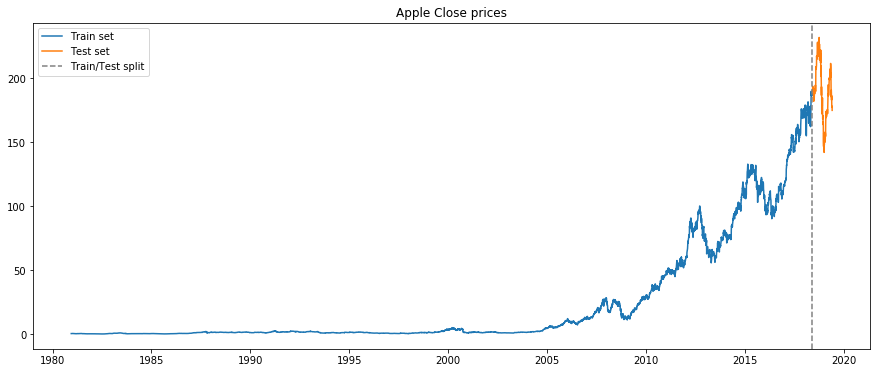

In [45]:
fig, ax = plt.subplots(figsize=(15, 6))
plt.plot(train)
plt.plot(test)
plt.axvline(x=train.index[-1], color='grey', linestyle='--', )
ax.set_title('Apple Close prices')
ax.legend(['Train set', 'Test set', 'Train/Test split'])

Let's perform some transformations. Transformations are used to stabilize the non-constant variance of a series. Common transformation methods include power transform, square root, and log transform. What kind of distribution do we have here?

In [46]:
train.describe()

count    9448.000000
mean       23.597855
std        41.856155
min         0.196429
25%         1.040179
50%         1.643214
75%        23.588572
max       190.039993
Name: Close, dtype: float64

In [47]:
def dist_plot(series, figsize=(15, 6)):
    plt.subplots(figsize=figsize)
    sns.distplot(series)

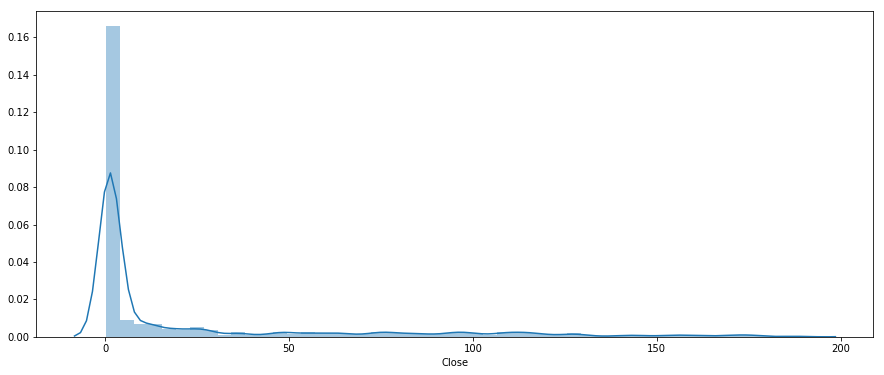

In [48]:
dist_plot(train)

As we can see it's right skewed. By applying a power transform we make it more-normal (Gaussian), removing a change in variance over time. We saw while exploring the trend that a polynomial fit, degree 4, seems to fit quite well the timeseries:

In [49]:
from numpy import polyfit

In [50]:
X = np.array([i for i in range(0, len(train))]).reshape(-1,)
y = np.array(train).reshape(-1,)

degree = 4

coef = polyfit(X, y, degree) 
print('Coefficients: %s' % coef)

Coefficients: [ 7.09507884e-14 -5.60994347e-10  7.19193546e-07  1.75692886e-03
 -8.80229001e-01]


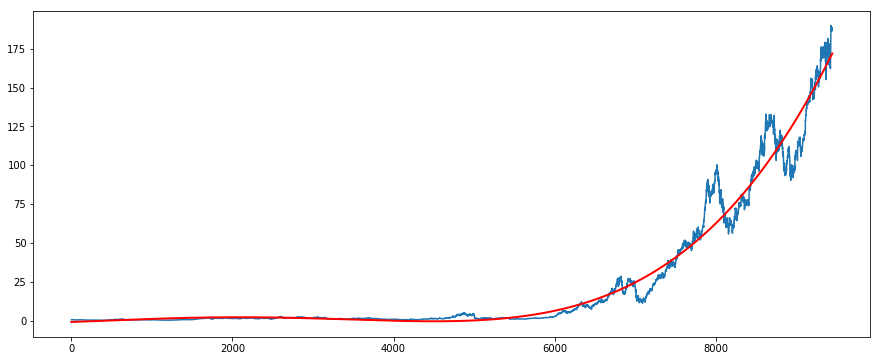

In [51]:
# create curve
curve = list()
for i in range(len(X)):
    value = coef[-1]
    for d in range(degree):
        value += X[i]**(degree-d) * coef[d]
    curve.append(value)
    
# plot curve over original data
plt.subplots(figsize=(15, 6))
plt.plot(y)
plt.plot(curve, color='red', linewidth=2)

Therefore let's apply this power transformation

In [52]:
power_1_4_series = np.power(train, 1/4)

In [53]:
power_1_4_series.describe()

count    9448.000000
mean        1.602472
std         0.861220
min         0.665735
25%         1.009897
50%         1.132201
75%         2.203816
max         3.712883
Name: Close, dtype: float64

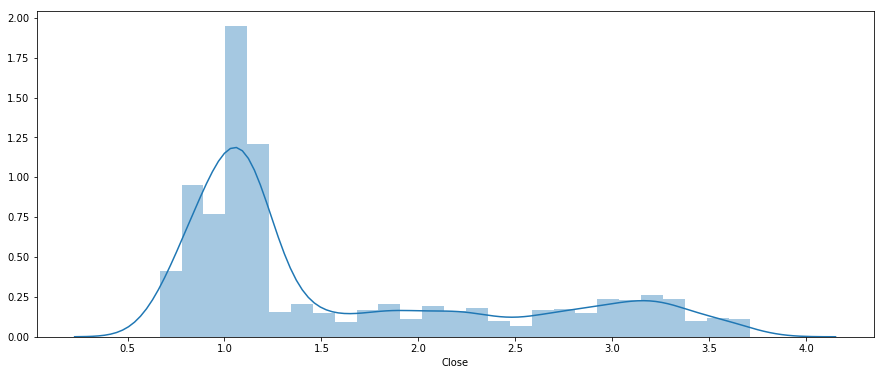

In [54]:
dist_plot(power_1_4_series)

Looks more gaussian-like, but not enough. Let's try log-transform

In [55]:
log_series = np.log(train)

In [56]:
log_series.describe()

count    9448.000000
mean        1.385558
std         1.929891
min        -1.627454
25%         0.039393
50%         0.496654
75%         3.160762
max         5.247235
Name: Close, dtype: float64

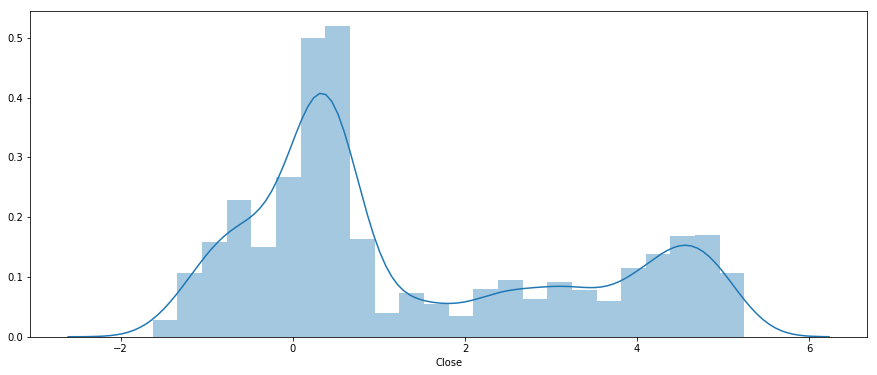

In [57]:
dist_plot(log_series)

A bit better. Let's make use of [Box-Cox test](http://scipy.github.io/devdocs/generated/scipy.stats.boxcox.html) to find the best transformation

In [58]:
from scipy.stats import boxcox

In [59]:
boxcox_series, lmbda = boxcox(train.values)
print('Best lmbda for Box-Cox test:', lmbda)

Best lmbda for Box-Cox test: -0.23066752434999835


In [60]:
pd.Series(boxcox_series).describe()

count    9448.000000
mean        0.893943
std         1.306610
min        -1.975028
25%         0.039214
50%         0.469261
75%         2.244139
max         3.042960
dtype: float64

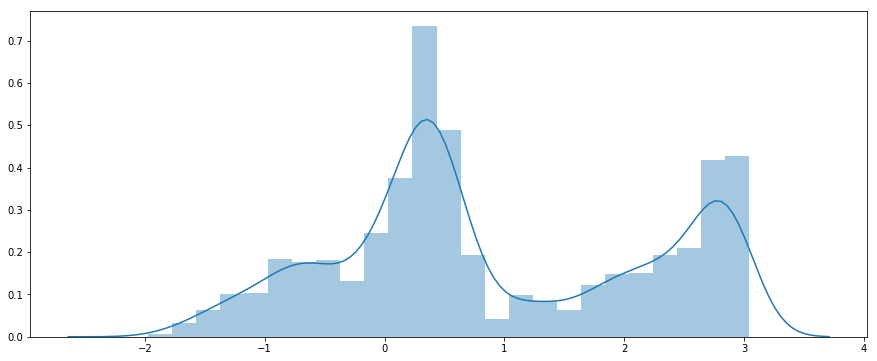

In [61]:
dist_plot(boxcox_series)

Looks a bit better. Let's now transformed also the test set using the `lmda` value provided by BoxCox

In [62]:
transformed_train = boxcox_series
transformed_test = boxcox(test, lmbda=lmbda)

Time to scale the values

In [63]:
from sklearn.preprocessing import MinMaxScaler

In [64]:
scaler = MinMaxScaler()

In [65]:
scaled_train = scaler.fit_transform(transformed_train.reshape(-1, 1))

In [66]:
scaled_test = scaler.transform(transformed_test.reshape(-1, 1))

In [67]:
pd.Series(scaled_train.reshape(-1,)).describe()

count    9448.000000
mean        0.571737
std         0.260385
min         0.000000
25%         0.401404
50%         0.487105
75%         0.840809
max         1.000000
dtype: float64

In [68]:
pd.Series(scaled_test.reshape(-1,)).describe()

count    251.000000
mean       0.999986
std        0.006823
min        0.982179
25%        0.995028
50%        1.000271
75%        1.005553
max        1.011600
dtype: float64

The next step is to split the sequence into features, `X`, and labels, `y`, to re-frame the timeseries forecasting as supervised learning problem

In [69]:
look_back = 3 # days back
X_train, y_train = split_sequence(scaled_train, look_back)
X_test, y_test = split_sequence(scaled_test, look_back)

In [70]:
print('Shape of X_train:', X_train.shape)
print('Shape of y_train:', y_train.shape)

Shape of X_train: (9445, 3, 1)
Shape of y_train: (9445, 1, 1)
